In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

import cv2

import matplotlib.pyplot as plt

import numpy as np

In [2]:
# if torch.cuda.is_available():
#     device = torch.device('cuda:0')
#     print("GPU build")
# else:
device = torch.device('cpu')
print("CPU build")
    
print(device)


CPU build
cpu


In [3]:
test_img = "/home/jwk6844/dataset/macroact/several/gettyimages-146171453-640_adpp_001.jpg"
test_img = cv2.imread(test_img)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

(360, 640, 3)


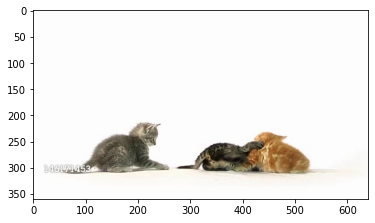

In [4]:
print(test_img.shape)
plt.imshow(test_img)
plt.show()

In [5]:
# object information : a set of bounding boxes [x1, y1, x2, y2] 
# and their labels
bbox0 = np.array([[80, 200, 250, 300], [300, 250, 430, 300], 
                  [380, 240, 530, 300]]) 
labels = np.array([1, 1, 1]) # 0: background, 1: zebra

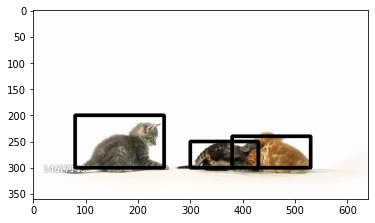

In [6]:
img_copy = np.copy(test_img)

for bbox in bbox0:
    cv2.rectangle(img_copy, (bbox[0], bbox[1]),(bbox[2], bbox[3]), color=(0,0,0), thickness=5)

plt.imshow(img_copy)

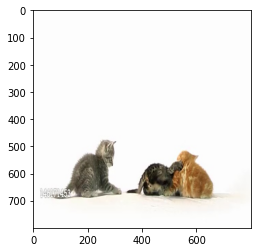

In [7]:
img = cv2.resize(test_img, dsize=(800,800), interpolation=cv2.INTER_CUBIC)
plt.imshow(img)

In [8]:
w_ratio = 800/test_img.shape[1]
h_ratio = 800/test_img.shape[0]

print("w_ratio : ", w_ratio)
print("h_ratio : ", h_ratio)

ratio = [w_ratio, h_ratio, w_ratio, h_ratio]
bbox = []

for box in bbox0:
    box = [int(b * r) for b, r in zip(box, ratio)]
    bbox.append(box)

bbox = np.array( bbox)
print("bbox : ", bbox)

w_ratio :  1.25
h_ratio :  2.2222222222222223
bbox :  [[100 444 312 666]
 [375 555 537 666]
 [475 533 662 666]]


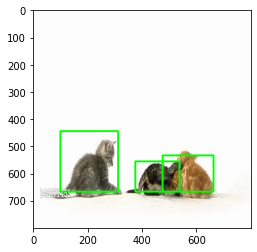

In [9]:
img_clone = np.copy(img)
for box in bbox:
    cv2.rectangle(img_clone, (box[0], box[1]), (box[2], box[3]), color = (0,255,0), thickness=5)

plt.imshow(img_clone)

# Feature extractor

In [10]:
model_vgg = torchvision.models.vgg16(pretrained=True).to(device)

In [11]:
features_vgg = list(model_vgg.features)

print("VGG : ", len(features_vgg))

VGG :  31


In [12]:
dummy = torch.zeros((1,3,800,800)).float()
print(dummy.shape)

req_features = []
out = dummy.clone().to(device)

for feature in features_vgg:
    out = feature(out)
    if out.shape[2] < 800//16:
        break
    req_features.append(feature)
    last_channels = out.shape[1]

print("VGG")   
print("layers : ",len(req_features))
print("last channels : ", last_channels)

torch.Size([1, 3, 800, 800])
VGG
layers :  30
last channels :  512


In [13]:
faster_r_cnn_extractor = nn.Sequential(*req_features)

In [14]:
torch.cuda.empty_cache()

In [15]:
transform = transforms.Compose([transforms.ToTensor()])
imgTensor = transform(img).to(device)
imgTensor = imgTensor.unsqueeze(0)
feature_map = faster_r_cnn_extractor(imgTensor)
print(feature_map.shape)

torch.Size([1, 512, 50, 50])


In [16]:
imgArray = feature_map.data.cpu().numpy().squeeze(0)
print("imgArray : ", imgArray.shape)

imgArray :  (512, 50, 50)


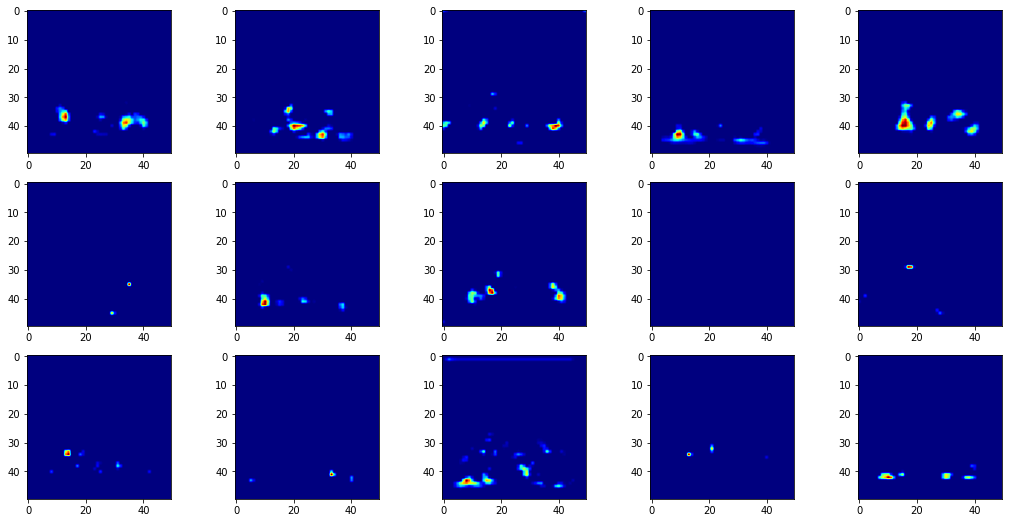

In [17]:
fig = plt.figure(figsize=(18,9))

for i in range(15):
    fig.add_subplot(3,5,i+1)
    plt.imshow(imgArray[i], cmap="jet")


# Generate Anchors Boxes

In [18]:
feature_size = 800//16
center_x = np.arange(16,(feature_size + 1)*16, 16)
center_y = np.arange(16,(feature_size + 1)*16, 16)
print("center_x : ", len(center_y))
print(center_y)

center_x :  50
[ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]


In [37]:
center = np.zeros((2500,2), dtype=np.int32)

for i in range(len(center_x)):
    for j in range(len(center_y)):
        center[i*50+j][0] = center_x[i] -(16//2)
        center[i*50+j][1] = center_y[j] -(16//2)

# center = [[center_x, center_y] ,,,]
print("center : ", center.shape)
print(center)

center :  (2500, 2)
[[  8   8]
 [  8  24]
 [  8  40]
 ...
 [792 760]
 [792 776]
 [792 792]]


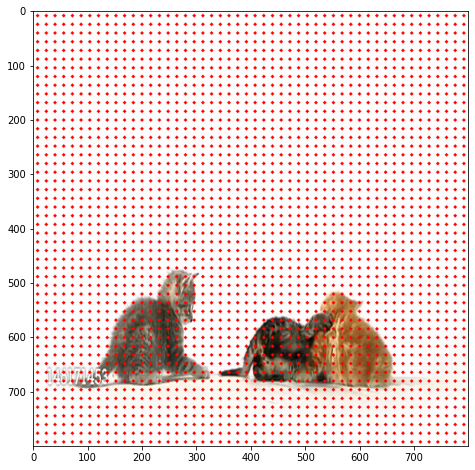

In [28]:
img_clone2 = np.copy(img)
ceter_int = center.astype("int32")

plt.figure(figsize=(8,8))

for xy in center:
    cv2.circle(img_clone2, (xy[0], xy[1]), radius=1, color=(255,0,0), thickness=3)

plt.imshow(img_clone2)
plt.show()

In [41]:
candi_ratio = [0.5,1,2]
candi_scale = [8,16,32]

sub_smapling = 800//feature_size
print("sub_smapling : ", sub_smapling)

# 50 * 50 * 9 * 4
anchor_boxes = np.zeros(((feature_size * feature_size * 9),4))

for i, c in enumerate(center):
    for r in candi_ratio:
        for s in candi_scale:
            w = s* np.sqrt(r)
            h = s * np.sqrt(1/r)

            # print(f'w : {w}, h : {h}')
            # print(f'c_x : {c[0]}, c_y : {c[1]}')

            anchor_boxes[i][0] = int(c[0] - w/2)
            anchor_boxes[i][1] = int(c[1] - w/2)
            anchor_boxes[i][2] = int(c[0] + w/2)
            anchor_boxes[i][3] = int(c[1] + w/2)

print("anchor_boxes : ", anchor_boxes.shape)
print(anchor_boxes)

sub_smapling :  16
anchor_boxes :  (22500, 4)
[[-14. -14.  30.  30.]
 [-14.   1.  30.  46.]
 [-14.  17.  30.  62.]
 ...
 [  0.   0.   0.   0.]
 [  0.   0.   0.   0.]
 [  0.   0.   0.   0.]]
